In [53]:
%load_ext autoreload
%autoreload 2

import argparse
import os
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import yaml
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

import src.BertClassifier as BertClassifier
import src.utils as utils
import wandb
from src.datasets import create_loo_dataset, create_test_sst2, create_train_sst2

device = utils.get_device()

config = utils.load_config(
    "bert_classifier.yaml", epochs=10, num_training_examples=1000
)

# Create datasets
train_dataset = create_train_sst2(
    device,
    num_samples=config["num_training_examples"],
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
)

test_dataset = create_test_sst2(
    device,
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 10777.54it/s]


{'epochs': 10,
 'bert_model_name': 'distilbert-base-uncased',
 'max_sequence_length': 64,
 'learning_rate': 0.005,
 'lr_warmup_pct': 0.2,
 'batch_size': 16,
 'classifier_type': 'single-fc',
 'classifier_hidden_size': 0,
 'classifier_drop_out': 0,
 'num_training_examples': 1000}

In [21]:
def train_model(
    train_dataset, test_dataset, config, wandb_project="LOO-test", wandb_tags=None
):
    train_dataloader = DataLoader(
        train_dataset, batch_size=config["batch_size"], shuffle=True
    )

    # Create classifcation model
    model = BertClassifier.create_bert_classifier(
        config["bert_model_name"],
        classifier_type=config["classifier_type"],
        classifier_hidden_size=config["classifier_hidden_size"],
        classifier_drop_out=config["classifier_drop_out"],
        freeze_bert=True,
        # random_state=42,
    )
    model.classifier.load_state_dict(
        torch.load("loo_10k/run_0/init_classifier_params.pt")
    )
    # torch.save(model.classifier.state_dict(), 'classifier_params.pt')

    optimizer = Adam(model.classifier.parameters(), lr=config["learning_rate"])
    loss_fn = torch.nn.CrossEntropyLoss()

    run = wandb.init(project=wandb_project, tags=wandb_tags, config=config)

    utils.train(
        config=config,
        model=model,
        optimizer=optimizer,
        train_dataloader=train_dataloader,
        val_dataloader=None,
    )

    fdf, test_loss, test_acc = utils.evaluate_loss_df(model, test_dataloader)
    wandb.summary["test/loss"] = test_loss
    wandb.summary["test/accuracy"] = test_acc
    wandb.finish()

    return model, fdf, test_loss, test_acc


full_model, fdf, full_test_loss, full_test_acc = train_model(
    train_dataset, test_dataset, config
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
wandb: Currently logged in as: patcao. Use `wandb login --relogin` to force relogin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:20<00:00, 30.86batch/s]


epoch,▁▃▅▆█
train/accuracy,▁▇▇██
train/batch_loss,▇▆▅▅▅▄▃▆█▄▅▂▇▄▆▃▃▆▂▃▅▁▂▂▃▂▃▄▁▄▂▂▆█▂▃▅▅▂▃
train/loss,█▃▃▂▁
epoch,5
test/accuracy,83.83028
test/loss,0.38231
train/accuracy,84.2
train/batch_loss,0.08196
train/loss,0.35668


In [34]:
firstq_loss = fdf.loss.quantile(0.25)
median_loss = fdf.loss.quantile(0.5)
thirdq_loss = fdf.loss.quantile(0.75)

In [42]:
df = fdf.copy()

In [48]:
# df = df.sort_values('loss')
# df['rank'] = 1
# df['rank'] = df['rank'].cumsum()
# df.sort_index().iloc[:15]

In [49]:
fdf[(fdf.loss >= firstq_loss) & (fdf.loss < median_loss)].iloc[:2]

,test_guid,logits,pred,label,loss
1,1,"[1.5613662, -1.4277569]",0,0,0.049106
3,3,"[-1.7622392, 1.5963509]",1,1,0.034193


In [50]:
fdf[(fdf.loss >= median_loss) & (fdf.loss < thirdq_loss)].iloc[:2]

,test_guid,logits,pred,label,loss
4,4,"[0.900454, -1.1592299]",0,0,0.119998
12,12,"[0.6718131, -0.91679406]",0,0,0.185824


In [51]:
fdf[(fdf.loss >= thirdq_loss)].iloc[:2]

,test_guid,logits,pred,label,loss
11,11,"[-0.2477861, 0.17904276]",1,0,0.929164
13,13,"[0.2667944, -0.8268993]",0,1,1.382608


### Compare Loo Pct Results

In [12]:
test_guids = [71, 102, 106, 270, 435, 700, 860]

fdf[fdf.test_guid.isin(test_guids)]

,test_guid,logits,pred,label,loss
71,71,"[-2.0081913, 1.8418145]",1,1,0.021056
102,102,"[-1.0249251, 0.6990137]",1,1,0.164126
106,106,"[0.52161086, -0.8465446]",0,1,1.594953
270,270,"[-2.71085, 2.8720965]",1,1,0.003754
435,435,"[-1.3103402, 0.9233117]",1,1,0.101777
700,700,"[0.44713104, -0.37645823]",0,0,0.363847
860,860,"[-1.8744478, 1.5857491]",1,1,0.030940


In [17]:
TEST_GUID = 435

df = pd.read_csv(f"loo_pct_10k/{TEST_GUID}-sweep.csv")
# base_line_loss = fdf[fdf.test_guid == TEST_GUID].loss.squeeze()

rand = df[(df.type == "rand") & (df.test_guid == TEST_GUID)]
rand = rand[["remove_pct", "loss"]]

zero = df[(df.type == "zero") & (df.test_guid == TEST_GUID)]
zero = zero[["remove_pct", "loss"]]

top = df[(df.type == "top") & (df.test_guid == TEST_GUID)]
top = top[["remove_pct", "loss"]]

bot = df[(df.type == "bot") & (df.test_guid == TEST_GUID)]
bot = bot[["remove_pct", "loss"]]

In [18]:
df[(df.type == "bot") & (df.test_guid == TEST_GUID)]

,test_guid,logits,pred,label,loss,type,remove_pct
2179,435,[-2.702465 2.3153768],1,1,6.596930e-03,bot,0.05
5667,435,[-3.2153273 2.8282342],1,1,2.370288e-03,bot,0.10
9155,435,[-3.8526661 3.4655783],1,1,6.630606e-04,bot,0.15
12643,435,[-4.25343 3.866335],1,1,2.975021e-04,bot,0.20
16131,435,[-4.6284075 4.241308 ],1,1,1.405379e-04,bot,0.25
19619,435,[-5.249097 4.8620005],1,1,4.064954e-05,bot,0.30
23107,435,[-6.2653055 5.878196 ],1,1,5.364403e-06,bot,0.40
26595,435,[-7.8448863 7.4576797],1,1,2.384186e-07,bot,0.50
30083,435,[-7.6418476 7.254645 ],1,1,3.576278e-07,bot,0.60
33571,435,[-6.991562 6.604369],1,1,1.192092e-06,bot,0.70


In [19]:
df[(df.type == "zero") & (df.test_guid == TEST_GUID)]

,test_guid,logits,pred,label,loss,type,remove_pct
3051,435,[-1.4991311 1.11204 ],1,1,0.070876,zero,0.05
6539,435,[-1.351237 0.96415573],1,1,0.094153,zero,0.10
10027,435,[-1.3828148 0.9957387],1,1,0.088638,zero,0.15
13515,435,[-1.2432653 0.85619426],1,1,0.115578,zero,0.20
17003,435,[-1.336996 0.94992507],1,1,0.096744,zero,0.25
20491,435,[-1.2286948 0.8416292],1,1,0.118800,zero,0.30
23979,435,[-0.9336303 0.5465692],1,1,0.205055,zero,0.40
27467,435,[-0.6202749 0.23322654],1,1,0.354818,zero,0.50
30955,435,[-0.48644245 0.09940041],1,1,0.442527,zero,0.60
34443,435,[-0.15056896 -0.2364658 ],0,1,0.737018,zero,0.70


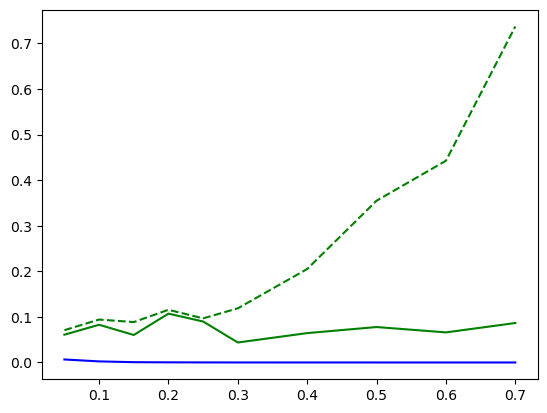

In [20]:
from matplotlib import pyplot as plt

plt.plot(rand.remove_pct, rand.loss, "g-")
plt.plot(zero.remove_pct, zero.loss, "g--")

# plt.plot(top.remove_pct, top.loss, 'r-')
plt.plot(bot.remove_pct, bot.loss, "b-")

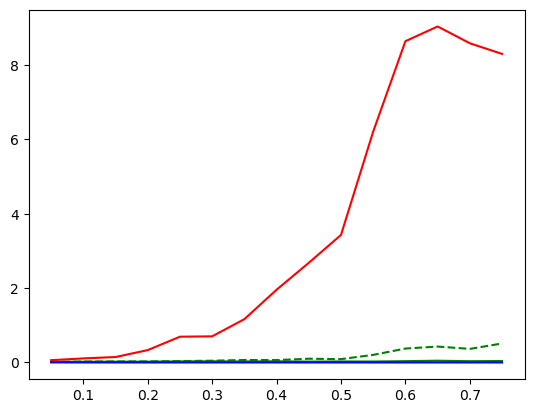

In [8]:
from matplotlib import pyplot as plt

plt.plot(rand.remove_pct, rand.loss, "g-")
plt.plot(zero.remove_pct, zero.loss, "g--")

plt.plot(top.remove_pct, top.loss, "r-")
plt.plot(bot.remove_pct, bot.loss, "b-")